In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot

In [2]:
np.random.seed(2024)

In [3]:
dim = 1
n = 1000

x_sample = np.random.multivariate_normal(np.zeros((dim,)), np.eye(dim), n)

y_sample = np.random.multivariate_normal(np.zeros((dim,)), np.eye(dim), n)

In [37]:
def mmd_experiment_single(kernel_class, Xs, Ys, theta, nboot=500, alpha=0.05):
    res = {
        "deviation": {"val": [], "threshold": [], "rej": []},
        "boot": {"val": [], "threshold": [], "pval": [], "rej": []},
        "robust": {"val": [], "threshold": [], "rej": []},
        "relaxed": {"val": [], "threshold": [], "rej": []},
    }

    for X, Y in tqdm(zip(Xs, Ys), total=Xs.shape[0]):
        kernel = kernel_class(sigma_sq=2.)
        mmd = metrics.MMD(kernel)
        val = mmd(X, Y)
        threshold = mmd.test_threshold(X.shape[0])
        
        # 1. deviation bound
        rej = mmd.reverse_test(X, Y, theta, alpha)

        # save results
        res["deviation"]["val"].append(val)
        res["deviation"]["threshold"].append(threshold)
        res["deviation"]["rej"].append(rej)
        
    return res

def mmd_experiment(kernel_class, Xs, Ys, theta, keys, nboot=500):
    """
    Xs: [array(nrep, n, d), ...]
    Ys: [array(nrep, n, d), ...]
    """
    res = {}
    for Xs_i, Ys_i, kk in zip(Xs, Ys, keys):
        print("key:", kk)
        res[kk] = mmd_experiment_single(kernel_class, Xs_i, Ys_i, theta, nboot=nboot)

    return res
    

In [94]:
np.random.seed(2024)

In [95]:
nrep = 10
n = 1000
dim = 1
mean1 = np.zeros((dim,)) + 1. # data
mean2 = np.zeros((dim,)) # model

### Gaussian loc
Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))

Ys = np.random.multivariate_normal(mean2, np.eye(dim), (nrep, n))
###

kernel_class = kernels.RBF

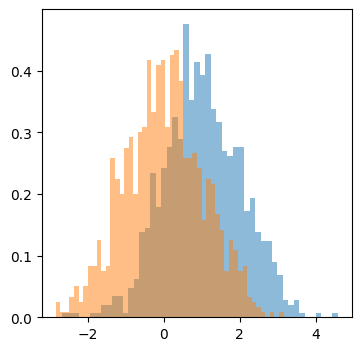

In [96]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
_ = ax.hist(Xs[0, :, 0], bins=50, label="X", alpha=0.5, density=True)
_ = ax.hist(Ys[0, :, 0], bins=50, label="Y", alpha=0.5, density=True)

In [97]:
theta = 1.
res = mmd_experiment_single(kernel_class, Xs, Ys, theta=theta, nboot=500)

  0%|          | 0/10 [00:00<?, ?it/s]

In [98]:
res["deviation"]["val"]

[0.1720179636345991,
 0.18428476926383563,
 0.19582963197821102,
 0.16876194066065464,
 0.18649441828899527,
 0.17913646195417887,
 0.18342694734633536,
 0.1783882833690058,
 0.1668056666349813,
 0.17507306934642775]

In [108]:
def population_mmd(mean, bandwidth_sq):
    """Compute population MMD under a mean-shift Gaussians setup
    """
    d = mean.shape[-1]
    mean_norm_sq = np.sum(mean**2)
    return 2 * (bandwidth_sq / (2. + bandwidth_sq))**(d/2) * (1 - np.exp(- mean_norm_sq / (2 * (2 + bandwidth_sq))))

def population_mmd_inverse(val, d, bandwidth_sq):
    """Compute the \| \mu \|_2^2 required for the population MMD 
    under a mean-shift Gaussians setup to equal to a given value.
    """
    c = 2 * (bandwidth_sq / (2. + bandwidth_sq))**(d/2)
    return -2. * (2 + bandwidth_sq) * np.log(1 - val / c)
    

In [109]:
np.sum((np.eye(dim)[:1, 0] * 1.)**2)

1.0

In [110]:
print(population_mmd(mean1, 1.))
print(np.mean(res["deviation"]["val"]))

0.17726763491986192
0.17902191524772246


In [111]:
population_mmd_inverse(population_mmd(mean1, 1.), dim, 1.)

0.9999999999999996

In [163]:
np.random.seed(2024)

In [164]:
nrep = 100
population_mmd_ls = [1e-1, 2e-1, 3e-1, 3.5e-1, 4e-1, 4.5e-1, 5e-1, 7.5e-1, 1.]
shift_sq_ls = [population_mmd_inverse(v, dim, 1.) for v in population_mmd_ls]

Xs_ls = []
Ys_ls = []

for shift_sq in shift_sq_ls:
    ### Gaussian loc
    mean1 = np.eye(dim)[:1, 0] * shift_sq**0.5
    mean2 = np.zeros((dim,))

    Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))
    Ys = np.random.multivariate_normal(mean2, np.eye(dim), (nrep, n))
    ###

    Xs_ls.append(Xs)
    Ys_ls.append(Ys)

kernel_class = kernels.RBF

keys = population_mmd_ls

In [165]:
theta = 0.5
res = mmd_experiment(kernel_class, Xs_ls, Ys_ls, theta=theta, keys=keys, nboot=500)

key: 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.2


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.3


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.35


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.4


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.45


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.75


  0%|          | 0/100 [00:00<?, ?it/s]

key: 1.0


  0%|          | 0/100 [00:00<?, ?it/s]

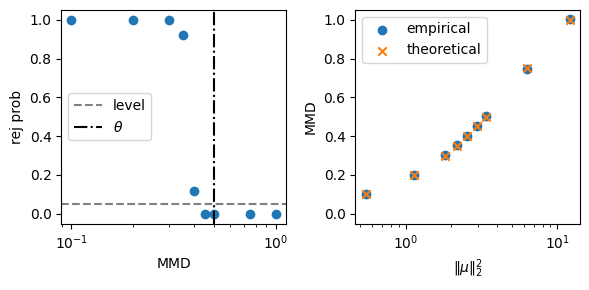

In [167]:
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

ax = axes[0]
rej_prob = [np.mean(res[kk]["deviation"]["rej"]) for kk in keys]
ax.scatter(keys, rej_prob)
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.axvline(theta, color="k", linestyle="-.", label=r"$\theta$")
ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("MMD")
ax.set_ylabel("rej prob")
ax.legend()

ax = axes[1]
vals = [np.mean(res[kk]["deviation"]["val"]) for kk in keys]
ax.scatter(shift_sq_ls, vals, label="empirical")
ax.scatter(shift_sq_ls, [population_mmd(np.eye(dim)[:1, 0] * s**0.5, 1.) for s in shift_sq_ls], marker="x", label="theoretical")
ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel(r"$\| \mu \|_2^2$")
ax.set_ylabel("MMD")
ax.legend()

_ = plt.tight_layout()